In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
# Charger les données MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalisation des données (les pixels doivent être entre 0 et 1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape des données pour que chaque image soit un vecteur compatible avec un MLP
x_train = x_train.reshape((-1, 28 * 28))
x_test = x_test.reshape((-1, 28 * 28))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


CNN MODEL


In [16]:
# Installer les bibliothèques nécessaires
!pip install keras-tuner --quiet

# Importer les bibliothèques
import keras
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [17]:
# Charger les données MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normaliser les données (valeurs entre 0 et 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Ajouter une dimension pour les canaux
x_train_cnn = np.expand_dims(x_train, axis=-1)
x_test_cnn = np.expand_dims(x_test, axis=-1)

print(f"Dimensions des données d'entraînement : {x_train_cnn.shape}")
print(f"Dimensions des étiquettes d'entraînement : {y_train.shape}")


Dimensions des données d'entraînement : (60000, 28, 28, 1)
Dimensions des étiquettes d'entraînement : (60000,)


In [18]:
# Définir le modèle CNN pour Keras Tuner
def construire_modele_cnn(hp):
    modele = keras.Sequential()
    modele.add(layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
        activation='relu',
        input_shape=(28, 28, 1)))
    modele.add(layers.MaxPooling2D(pool_size=2))
    modele.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.6, step=0.1)))

    modele.add(layers.Conv2D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation='relu'))
    modele.add(layers.MaxPooling2D(pool_size=2))
    modele.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.6, step=0.1)))

    modele.add(layers.Flatten())
    modele.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'))
    modele.add(layers.Dropout(hp.Float('dropout_dense', min_value=0.2, max_value=0.6, step=0.1)))

    modele.add(layers.Dense(10, activation='softmax'))

    modele.compile(optimizer=keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return modele

# Lancer la recherche d'hyperparamètres
tuner_cnn = kt.RandomSearch(
    construire_modele_cnn,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='mnist_tuning_cnn',
    project_name='cnn_tuning'
)

tuner_cnn.search(x_train_cnn, y_train, epochs=10, validation_data=(x_test_cnn, y_test))

# Obtenir les meilleurs hyperparamètres
meilleurs_hps = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]
print(f"Meilleurs hyperparamètres trouvés : {meilleurs_hps.values}")

# Construire et entraîner le modèle final
modele_optimal = tuner_cnn.hypermodel.build(meilleurs_hps)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
historique = modele_optimal.fit(x_train_cnn, y_train, epochs=15, validation_data=(x_test_cnn, y_test), callbacks=[early_stopping])


Trial 15 Complete [00h 00m 43s]
val_accuracy: 0.9763000011444092

Best val_accuracy So Far: 0.9944999814033508
Total elapsed time: 00h 10m 44s
Meilleurs hyperparamètres trouvés : {'filters_1': 32, 'kernel_size_1': 3, 'dropout_1': 0.2, 'filters_2': 128, 'kernel_size_2': 5, 'dropout_2': 0.30000000000000004, 'dense_units': 128, 'dropout_dense': 0.5, 'learning_rate': 0.001}
Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8601 - loss: 0.4330 - val_accuracy: 0.9878 - val_loss: 0.0400
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9761 - loss: 0.0784 - val_accuracy: 0.9908 - val_loss: 0.0276
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9832 - loss: 0.0558 - val_accuracy: 0.9929 - val_loss: 0.0227
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9851 - loss: 0.0474 - val_accuracy: 0.9919 - val_loss: 0.0239
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9871 - loss: 0.0416 - val_accuracy: 0.9

313/313 - 0s - 1ms/step - accuracy: 0.9939 - loss: 0.0200
Loss sur le test: 0.02004176564514637
Accuracy sur le test: 0.9939000010490417
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


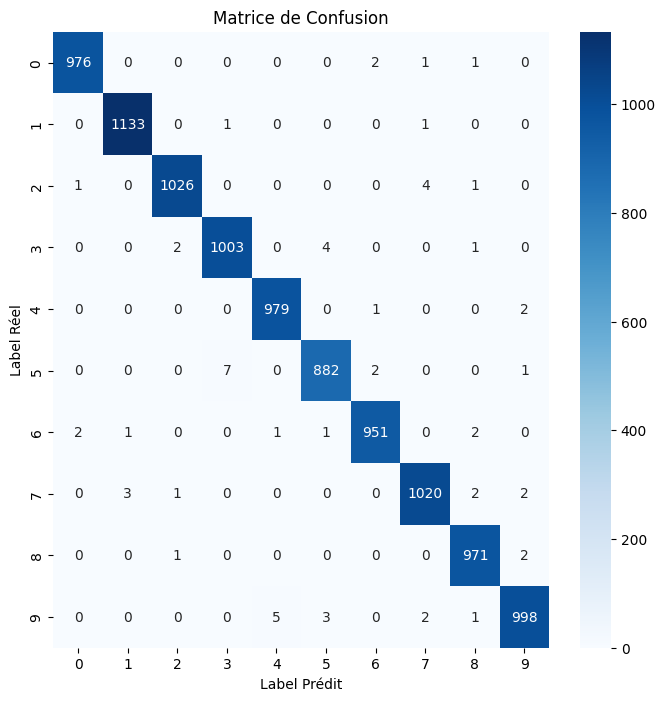

Catégories les plus confondues (Vrai, Prédit, Fréquence) :
Vrai: 5, Prédit: 3, Fréquence: 7
Vrai: 9, Prédit: 4, Fréquence: 5
Vrai: 2, Prédit: 7, Fréquence: 4
Vrai: 3, Prédit: 5, Fréquence: 4
Vrai: 7, Prédit: 1, Fréquence: 3


In [19]:
# Évaluer les performances sur le jeu de test
test_loss, test_accuracy = modele_optimal.evaluate(x_test_cnn, y_test, verbose=2)
print(f"Loss sur le test: {test_loss}")
print(f"Accuracy sur le test: {test_accuracy}")

# Faire des prédictions
predictions = modele_optimal.predict(x_test_cnn)
predicted_labels = np.argmax(predictions, axis=1)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Matrice de Confusion")
plt.xlabel("Label Prédit")
plt.ylabel("Label Réel")
plt.show()

# Catégories les plus confondues
confused_pairs = []
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        if i != j and conf_matrix[i][j] > 0:
            confused_pairs.append((i, j, conf_matrix[i][j]))
confused_pairs = sorted(confused_pairs, key=lambda x: x[2], reverse=True)

print("Catégories les plus confondues (Vrai, Prédit, Fréquence) :")
for pair in confused_pairs[:5]:
    print(f"Vrai: {pair[0]}, Prédit: {pair[1]}, Fréquence: {pair[2]}")


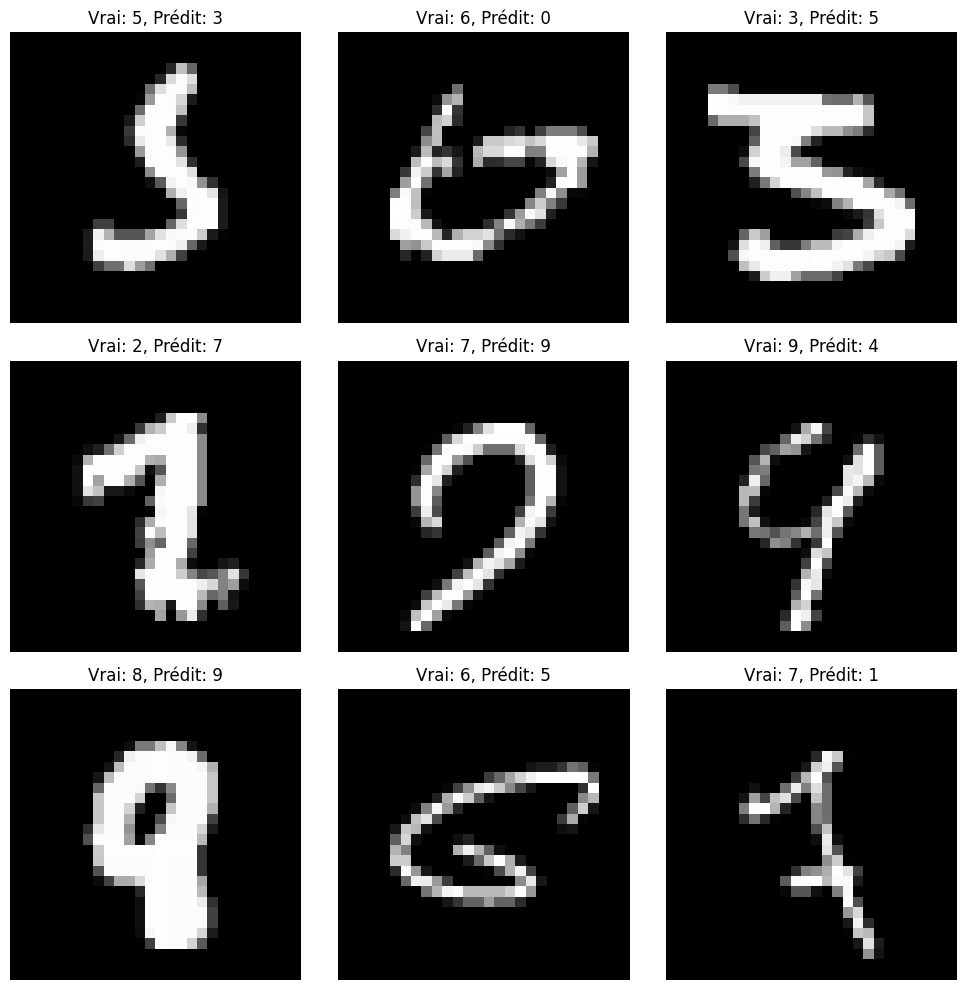

In [20]:
# Visualiser quelques exemples mal classés
plt.figure(figsize=(10, 10))
erreurs_indices = np.where(y_test != predicted_labels)[0]
for i, idx in enumerate(erreurs_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test_cnn[idx].reshape(28, 28), cmap="gray")
    plt.title(f"Vrai: {y_test[idx]}, Prédit: {predicted_labels[idx]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


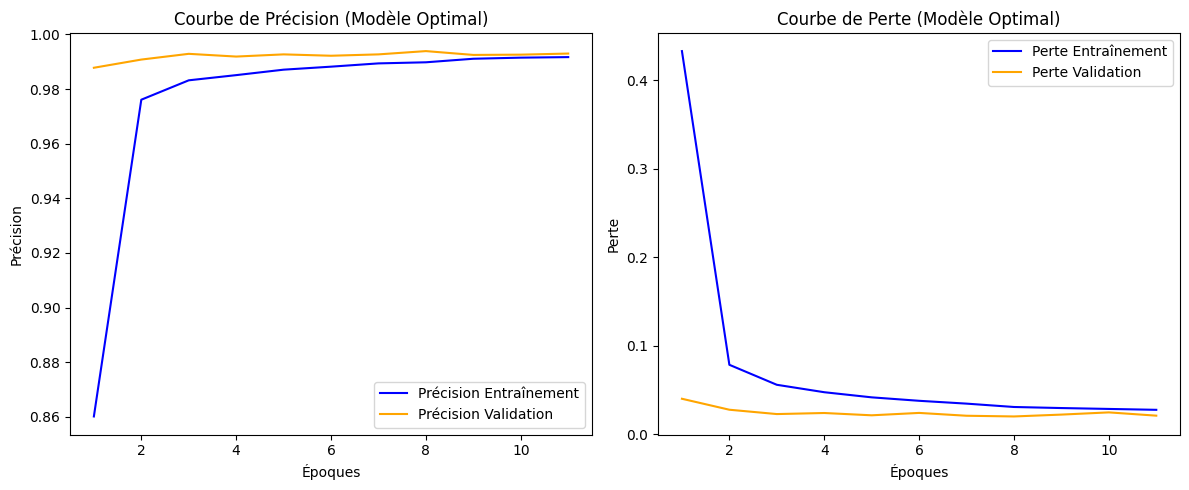

In [21]:
import matplotlib.pyplot as plt

# Données du modèle CNN
epoques = list(range(1, 12))  # Époques de 1 à 11
precision_train = [0.8601, 0.9761, 0.9832, 0.9851, 0.9871, 0.9882, 0.9894, 0.9898, 0.9911, 0.9915, 0.9917]
precision_val = [0.9878, 0.9908, 0.9929, 0.9919, 0.9927, 0.9922, 0.9927, 0.9939, 0.9925, 0.9926, 0.9930]
perte_train = [0.4330, 0.0784, 0.0558, 0.0474, 0.0416, 0.0377, 0.0345, 0.0307, 0.0295, 0.0285, 0.0275]
perte_val = [0.0400, 0.0276, 0.0227, 0.0239, 0.0213, 0.0240, 0.0208, 0.0200, 0.0221, 0.0246, 0.0209]

# Création des graphiques
plt.figure(figsize=(12, 5))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(epoques, precision_train, label='Précision Entraînement', color='blue')
plt.plot(epoques, precision_val, label='Précision Validation', color='orange')
plt.title("Courbe de Précision (Modèle Optimal)")
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(epoques, perte_train, label='Perte Entraînement', color='blue')
plt.plot(epoques, perte_val, label='Perte Validation', color='orange')
plt.title("Courbe de Perte (Modèle Optimal)")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# Ajustement de la disposition et affichage
plt.tight_layout()
plt.show()
